In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

# Prediction Using Machine Learning
## Setting up the target column

In [2]:
df = pickle.load(open('clean_df.pkl', 'rb'))

In [3]:
df['result'].value_counts()

W    2130
L     834
D     750
Name: result, dtype: int64

As can be seen from above, the result column is not balanced. Also, according to our brief of predicting if the game is going ot be a win or "not", we will have a binary target column, the result is either a win or loss. Te reason the number of wins is a lot higher than the losses and draws is that these tea have qualified for the Champions League. The qualifying teams win the majority of their games in the domestic leagues as well. 

In [4]:
df = df.sort_values("date")
df=df.reset_index(drop=True)
df.groupby(["venue"]).apply(lambda x: x[x["result"] == 'W'].shape[0]/ x.shape[0])

venue
Away       0.524476
Home       0.624795
Neutral    0.458333
dtype: float64

In [5]:
df.venue.value_counts() # this is not balanced. Have to drop the venues that are neutral. It is only 24 rows. 

Away       1859
Home       1831
Neutral      24
Name: venue, dtype: int64

In [6]:
df = df.loc[df['venue']!='Neutral'] # dropping venue = neutral. 
df.groupby(["venue"]).apply(lambda x: x[x["result"] == 'W'].shape[0]/ x.shape[0]) # So in %62 of the cases, the team wins their home games, as opposed to onl 52% of their away games. 
# This is our benchmark.

venue
Away    0.524476
Home    0.624795
dtype: float64

In [7]:
df['target'] = (df['result'] == "W").astype("int")

## Using a Random Forrest Classifier

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### Just the initial predictors

In [9]:
predictors = ["venue_code", "opp_code", "hour", "day_code", 'round_code', 'comp_code'] # initial predictors 

In [10]:
rf = RandomForestClassifier(n_estimators=500, min_samples_split=2, random_state=1, class_weight='balanced')

train = df[df['date']< "2022-08-15"] # Using 70% of the rows for training and 30% for testing. cannot do splits since we cannot use future data to predict past games. 
test = df[df['date']> "2022-08-15"]

rf.fit(train[predictors],train['target'])

predictions = rf.predict(test[predictors])

print(train.shape)
print(test.shape)

accuracy_score(test["target"],predictions)

print('accuracy_score =' ,accuracy_score(test["target"],predictions))

(2760, 68)
(926, 68)
accuracy_score = 0.5993520518358532


In [11]:
combined = pd.DataFrame(dict(actual=test["target"], predicted=predictions))
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,170,217
1,154,385


Accuracy score here is not a good measure, we use precision score as we have false positives and false negatives. 0 is a loss and 1 is a win. 

In [12]:
from sklearn.metrics import precision_score

precision_score(test["target"], predictions, average = None) # this shows that we predict %46 for away games and %62 for home games. We need to improve on this.

array([0.52469136, 0.63953488])

In [13]:
precision_score(test["target"], predictions, average = 'weighted')

0.5915387234137549

As we can see we do not beat the home/way benchmark only using these features. we will need more features. 

## Feature Engineering
We need to use the rest of the statistics we have to see if we can improve our model. Hence we introduce rolling averages of statistics from previous games as prediction metrics. We have to be careful not to feed any information to the model for predicting a game when we won't have the information. Yu cannot have goals for in the predictors, as that information is known after the game! 

In [14]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(5,closed="left").mean() # closed = left -> to avoid data leakage from future matches
    group[new_cols] = rolling_stats
    group = group.dropna(subset = new_cols)
    return group

In [15]:
def make_predictions(data, predictors):
    rf = RandomForestClassifier(n_estimators=500, min_samples_split=2, random_state=1)

    train = data[data['date']< "2022-8-15"] # Data in order of date use 70% for training
    test = data[data['date']> "2022-8-15"]

    rf.fit(train[predictors],train['target'])

    predictions = rf.predict(test[predictors])

    combined = pd.DataFrame(dict(actual=test["target"], predicted=predictions))

    precision_weight = precision_score(test["target"], predictions, average = 'weighted')
    precision_raw = precision_score(test["target"], predictions, average = None)

    
    ConfusionMatrixDisplay.from_estimator(rf, test[predictors], test["target"], display_labels=['won','not won'], cmap=plt.cm.Blues, normalize='true')

    return combined, precision_weight, precision_raw, rf.feature_importances_, rf

### Trying some features based on domain knowledge.

The raw precision [Away, Home] is: [0.60071942 0.66987179]
The weighted precision is: 0.6412755263979163


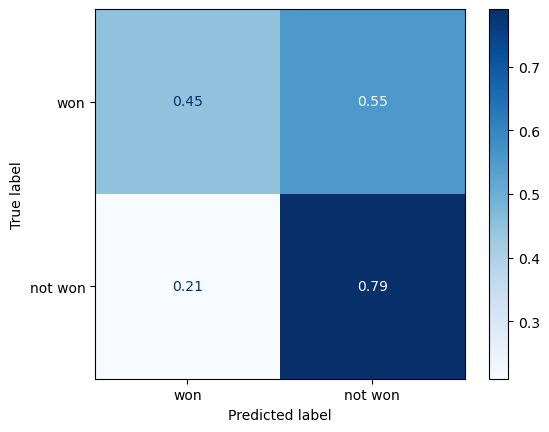

In [16]:
cols = ['gls','gls_opp','gf','gf_opp','sh', 'sot','g/sh','save%_opp','tkl+int','poss_x'] # Choosing based on domain knowledge.
new_cols = [f"{c}_rolling" for c in cols] # add_rolling to column names

df_rolling = df.groupby('team').apply(lambda x: rolling_averages(x,cols,new_cols))
df_rolling = df_rolling.droplevel('team')

combined, precision_weight, precision_raw, importances, rf = make_predictions (df_rolling, predictors+new_cols)

print("The raw precision [Away, Home] is:",precision_raw)
print("The weighted precision is:", precision_weight)

In [17]:
df.groupby(["venue"]).apply(lambda x: x[x["result"] == 'W'].shape[0]/ x.shape[0]) # What we get by predicting home wins, i.e. %62 of the home games are won and %52 of the away games. 

venue
Away    0.524476
Home    0.624795
dtype: float64

We are already over the benchmark with the above stats, but we will try and improve. 

In [18]:
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,167,206
1,111,418


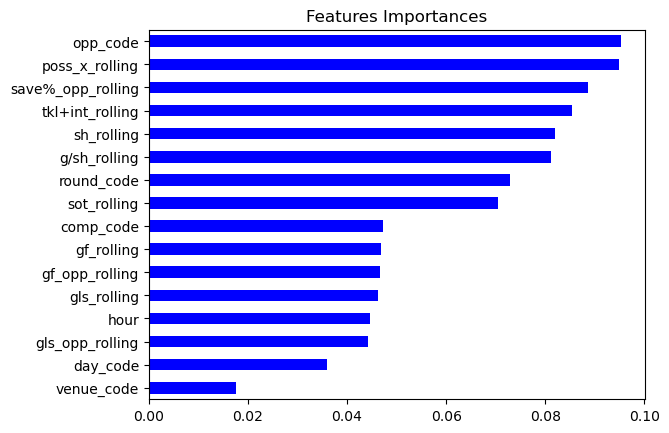

In [19]:
importance = pd.Series(data=importances,
                        index=  predictors+new_cols)
# Sort importances
importances_sorted = importance.sort_values()
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='blue')
plt.title('Features Importances')
plt.show()

### Using all the columns by getting a rolling average for them. 

In [20]:
predictors

['venue_code', 'opp_code', 'hour', 'day_code', 'round_code', 'comp_code']

In [21]:
df.shape

(3690, 68)

[0.58064516 0.63941606]
0.6151127938490036


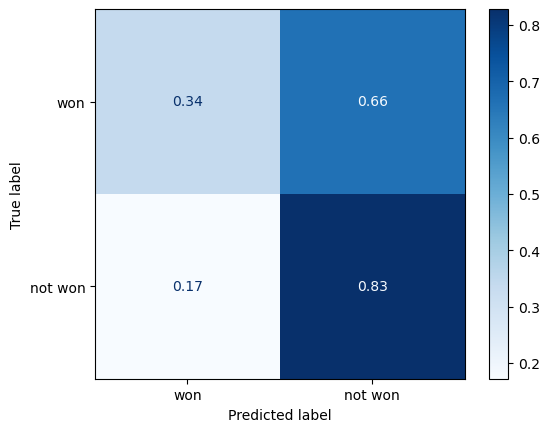

In [22]:
cols = ['gf',
       'gls', 'sh', 'sot', 'sot%', 'g/sh', 'pk', 'pkatt', 'gf_opp', 'gls_opp',
       'sh_opp', 'sot_opp', 'sot%_opp', 'g/sh_opp', 'pk_opp', 'pkatt_opp',
       'sota', 'saves', 'cs', 'pka', 'pksv', 'pkm', 'sota_opp', 'saves_opp',
       'save%_opp', 'cs_opp', 'pka_opp', 'pksv_opp', 'pkm_opp', 'ast',
       'ast_opp', 'crs', 'crs_opp', 'tklw', 'int', 'tkl+int', 'tklw_opp',
       'int_opp', 'tkl+int_opp', 'poss_x', 'poss_opp', 'crdy', 'crdr', '2crdy',
       'fls', 'og', 'crdy_opp', 'crdr_opp', '2crdy_opp', 'fls_opp', 'og_opp',
       ]

rolling_cols = [f"{c}_rolling" for c in cols] # add_rolling to column names

df_rolling = df.groupby('team').apply(lambda x: rolling_averages(x,cols,rolling_cols))
df_rolling = df_rolling.droplevel('team')

all_cols = rolling_cols+predictors

combined, precision_weight, precision_raw, importances, rf = make_predictions (df_rolling, all_cols)

print(precision_raw)
print(precision_weight)

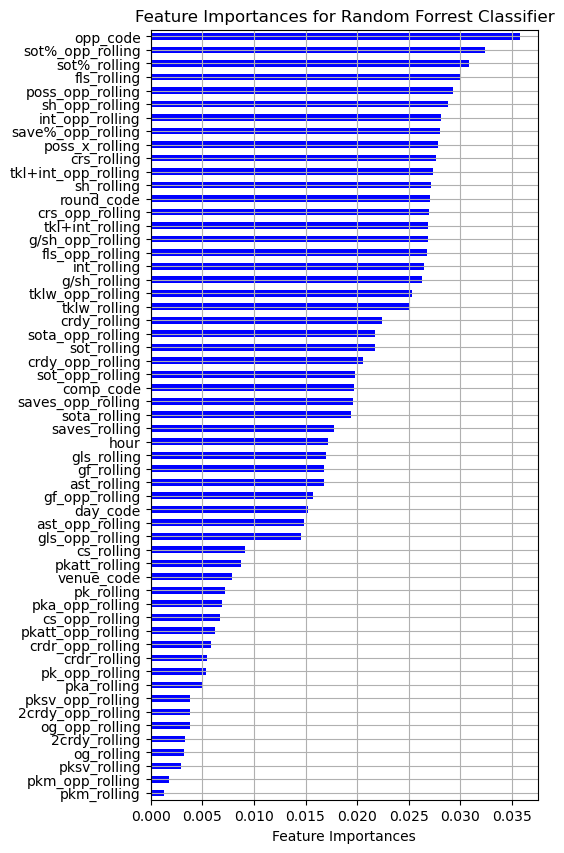

In [23]:
importance = pd.Series(data=importances, index=  all_cols)
# Sort importances
importances_sorted = importance.sort_values()
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='blue', figsize = (5,10), grid = True, xlabel = 'Feature Importances')
plt.title('Feature Importances for Random Forrest Classifier')
plt.show()

We rank the features based on their importance, and then we prune the least important ones. 

In [24]:
data ={'imp_vals':importances}
imp_df = pd.DataFrame(data=data, index=all_cols)
imp_df.sort_values(by = 'imp_vals')

,imp_vals
pkm_rolling,0.001336
pkm_opp_rolling,0.001806
pksv_rolling,0.002954
og_rolling,0.003190
2crdy_rolling,0.003339
og_opp_rolling,0.003820
2crdy_opp_rolling,0.003847
pksv_opp_rolling,0.003862
pka_rolling,0.005037
pk_opp_rolling,0.005400


[0.61085973 0.65051395]
0.6341159183169308


predicted,0,1
actual,,
0,135,238
1,86,443


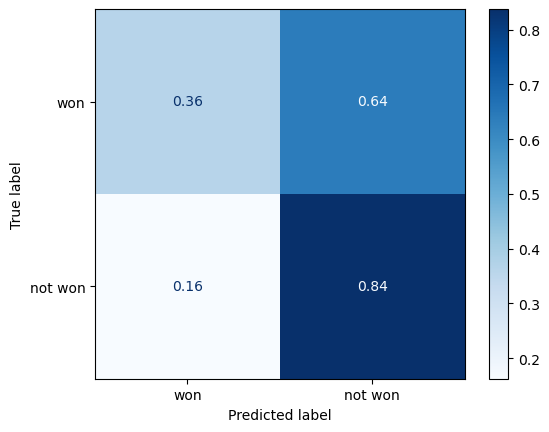

In [25]:
predictors3 = imp_df.loc[imp_df['imp_vals']>0.01].index # Selecting from the chosen features, and removing the east important ones. 
combined, precision_weight, precision_raw, importances,rf = make_predictions (df_rolling, predictors3)

print(precision_raw)
print(precision_weight)

pd.crosstab(index=combined["actual"], columns=combined["predicted"])

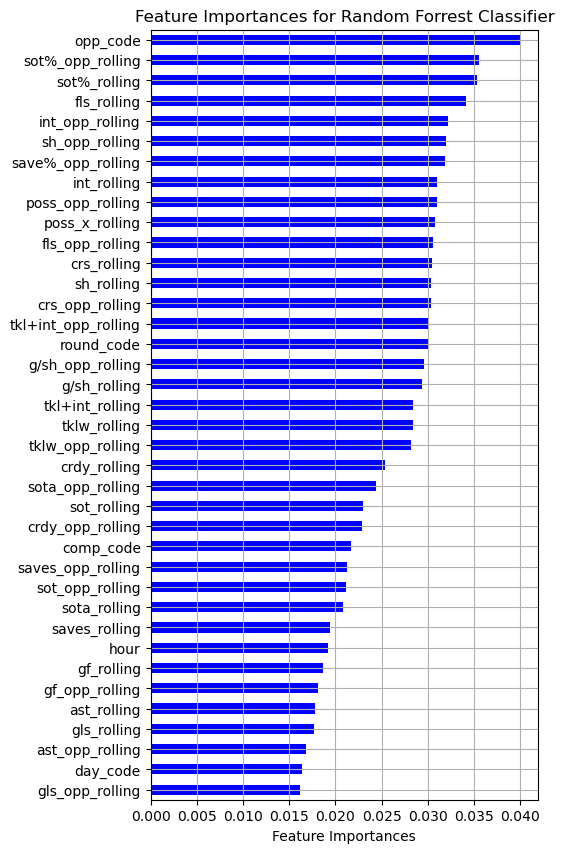

In [26]:
importance = pd.Series(data=importances, index=  predictors3)
# Sort importances
importances_sorted = importance.sort_values()
# Draw a horizontal barplot of importances_sorted

importances_sorted.plot(kind='barh', color='blue',figsize = (5,10), grid = True, xlabel = 'Feature Importances')
plt.title('Feature Importances for Random Forrest Classifier')
plt.show()

Hence we have beaten the benchmark using selected features. Using the sequential feature selection to see if we can improve the score did not yield any results that could beat the above. 

In [27]:
# Adding the best model to Pickle

file = open('appData.pickle', 'wb')
data = [combined, precision_weight, precision_raw, importances_sorted,rf, predictors3, df_rolling]
# dump information to that file
pickle.dump(data, file)
file.close()

## More feature Engineering with summation. 

[0.55263158 0.63353116]
0.6000771187840511


predicted,0,1
actual,,
0,126,247
1,102,427


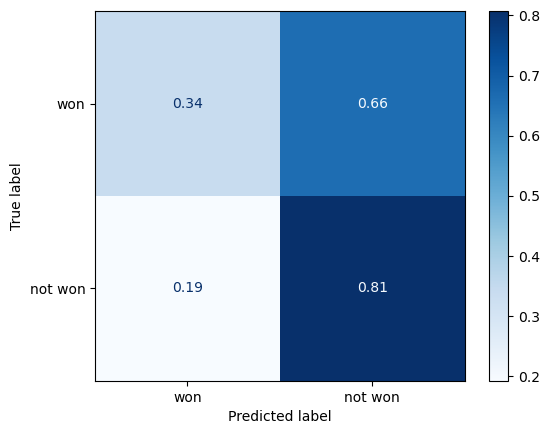

In [28]:
df_rolling["fls_rolling+sot%_rolling"] = df_rolling["fls_rolling"]+df_rolling['sot%_rolling']
predictors3 = list(predictors3) + ["fls_rolling+sot%_rolling"] # Adding two columns together
combined, precision_weight, precision_raw, importances,rf = make_predictions (df_rolling, predictors3)
print(precision_raw)
print(precision_weight)
pd.crosstab(index=combined["actual"], columns=combined["predicted"])


No improvement

In [29]:
len(df[df['season']=='2022-2023']['team'].unique()) #32 teams checks out

32

## Prediction Using XGBoost

In [30]:
import xgboost as xgb

#XGBClassifier default parameters are not available without fitting the model
XGB_model = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', eval_metric='auc')
XGB_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'auc',
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

Using minmax scaling to prepare for XG boost. 

In [31]:
df_rolling[rolling_cols] = (df_rolling[rolling_cols]-df_rolling[rolling_cols].min())/(df_rolling[rolling_cols].max()-df_rolling[rolling_cols].min())

In [32]:
def make_xgb_predictions(XGB_model, data, predictors):
    train = data[data['date']< "2022-8-15"] # Data in order of date use 70% for training
    test = data[data['date']> "2022-8-15"]
    
    eval_set = [(train[predictors], train['target']), (test[predictors], test['target'])]

    XGB_model.fit(train[predictors],train['target'], eval_set=eval_set, verbose=True)

    predictions = XGB_model.predict(test[predictors])

    combined = pd.DataFrame(dict(actual=test["target"], predicted=predictions))

    precision_weight = precision_score(test["target"], predictions, average = 'weighted')
    precision_raw = precision_score(test["target"], predictions, average = None)

    return combined, precision_weight, precision_raw, XGB_model.feature_importances_, XGB_model

In [33]:
df_rolling.head() # Normalised now (range between 0,1)

,date,time,comp,round,day,venue,result,gf,opponent,gls,...,crdr_rolling,2crdy_rolling,fls_rolling,og_rolling,crdy_opp_rolling,crdr_opp_rolling,2crdy_opp_rolling,fls_opp_rolling,og_opp_rolling,fls_rolling+sot%_rolling
193,2020-10-21,21:00,Champions Lg,Group stage,Wed,Home,L,0,Liverpool,0.0,...,0.50,0.0,0.351351,0.000000,0.269231,0.2,0.0,0.421053,0.0,39.12
222,2020-10-24,16:30,Eredivisie,Regular season,Sat,Away,W,13,VVV-Venlo,13.0,...,0.25,0.0,0.310811,0.333333,0.269231,0.2,0.0,0.368421,0.0,36.30
241,2020-10-27,21:00,Champions Lg,Group stage,Tue,Away,D,2,Atalanta,2.0,...,0.25,0.0,0.324324,0.333333,0.307692,0.2,0.0,0.447368,0.0,37.80
266,2020-10-31,20:00,Eredivisie,Regular season,Sat,Home,W,5,Fortuna Sittard,5.0,...,0.00,0.0,0.364865,0.333333,0.269231,0.2,0.0,0.407895,0.0,43.96
291,2020-11-03,21:00,Champions Lg,Group stage,Tue,Away,W,2,Midtjylland,2.0,...,0.00,0.0,0.405405,0.333333,0.307692,0.2,0.0,0.421053,0.0,47.52


In [34]:
combined, precision_weight, precision_raw, importances,XGB_model = make_xgb_predictions (XGB_model,df_rolling, all_cols)

[0]	validation_0-auc:0.72964	validation_1-auc:0.58294
[1]	validation_0-auc:0.78897	validation_1-auc:0.57448
[2]	validation_0-auc:0.83314	validation_1-auc:0.57526
[3]	validation_0-auc:0.85794	validation_1-auc:0.58427
[4]	validation_0-auc:0.87544	validation_1-auc:0.59308
[5]	validation_0-auc:0.89370	validation_1-auc:0.59510
[6]	validation_0-auc:0.91244	validation_1-auc:0.59984
[7]	validation_0-auc:0.92077	validation_1-auc:0.60429
[8]	validation_0-auc:0.93319	validation_1-auc:0.60620
[9]	validation_0-auc:0.93896	validation_1-auc:0.61043
[10]	validation_0-auc:0.94096	validation_1-auc:0.60759
[11]	validation_0-auc:0.95233	validation_1-auc:0.61101
[12]	validation_0-auc:0.96042	validation_1-auc:0.62158
[13]	validation_0-auc:0.96573	validation_1-auc:0.62266
[14]	validation_0-auc:0.96812	validation_1-auc:0.62198
[15]	validation_0-auc:0.97200	validation_1-auc:0.61727
[16]	validation_0-auc:0.97678	validation_1-auc:0.61309
[17]	validation_0-auc:0.97965	validation_1-auc:0.61969
[18]	validation_0-au

In [35]:
print(precision_raw)
print(precision_weight)
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

[0.52252252 0.65026362]
0.5974394191634537


predicted,0,1
actual,,
0,174,199
1,159,370


Not as good as the random forrest classifier. 

In [36]:
a = pd.crosstab(index=combined["actual"], columns=combined["predicted"])

Have to divide by the sum of each row to maintain consistancy with the random forrest confusion matrix plots. 

In [37]:
a = a.div(a.sum(axis=1), axis = 0)
import plotly.express as px

fig = px.imshow(a, color_continuous_scale='blues', text_auto=True, x = ['not won', 'won'], y = ['won','not won'])
fig.show()

In [38]:
predictors3

['gf_rolling',
 'gls_rolling',
 'sh_rolling',
 'sot_rolling',
 'sot%_rolling',
 'g/sh_rolling',
 'gf_opp_rolling',
 'gls_opp_rolling',
 'sh_opp_rolling',
 'sot_opp_rolling',
 'sot%_opp_rolling',
 'g/sh_opp_rolling',
 'sota_rolling',
 'saves_rolling',
 'sota_opp_rolling',
 'saves_opp_rolling',
 'save%_opp_rolling',
 'ast_rolling',
 'ast_opp_rolling',
 'crs_rolling',
 'crs_opp_rolling',
 'tklw_rolling',
 'int_rolling',
 'tkl+int_rolling',
 'tklw_opp_rolling',
 'int_opp_rolling',
 'tkl+int_opp_rolling',
 'poss_x_rolling',
 'poss_opp_rolling',
 'crdy_rolling',
 'fls_rolling',
 'crdy_opp_rolling',
 'fls_opp_rolling',
 'opp_code',
 'hour',
 'day_code',
 'round_code',
 'comp_code',
 'fls_rolling+sot%_rolling']

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

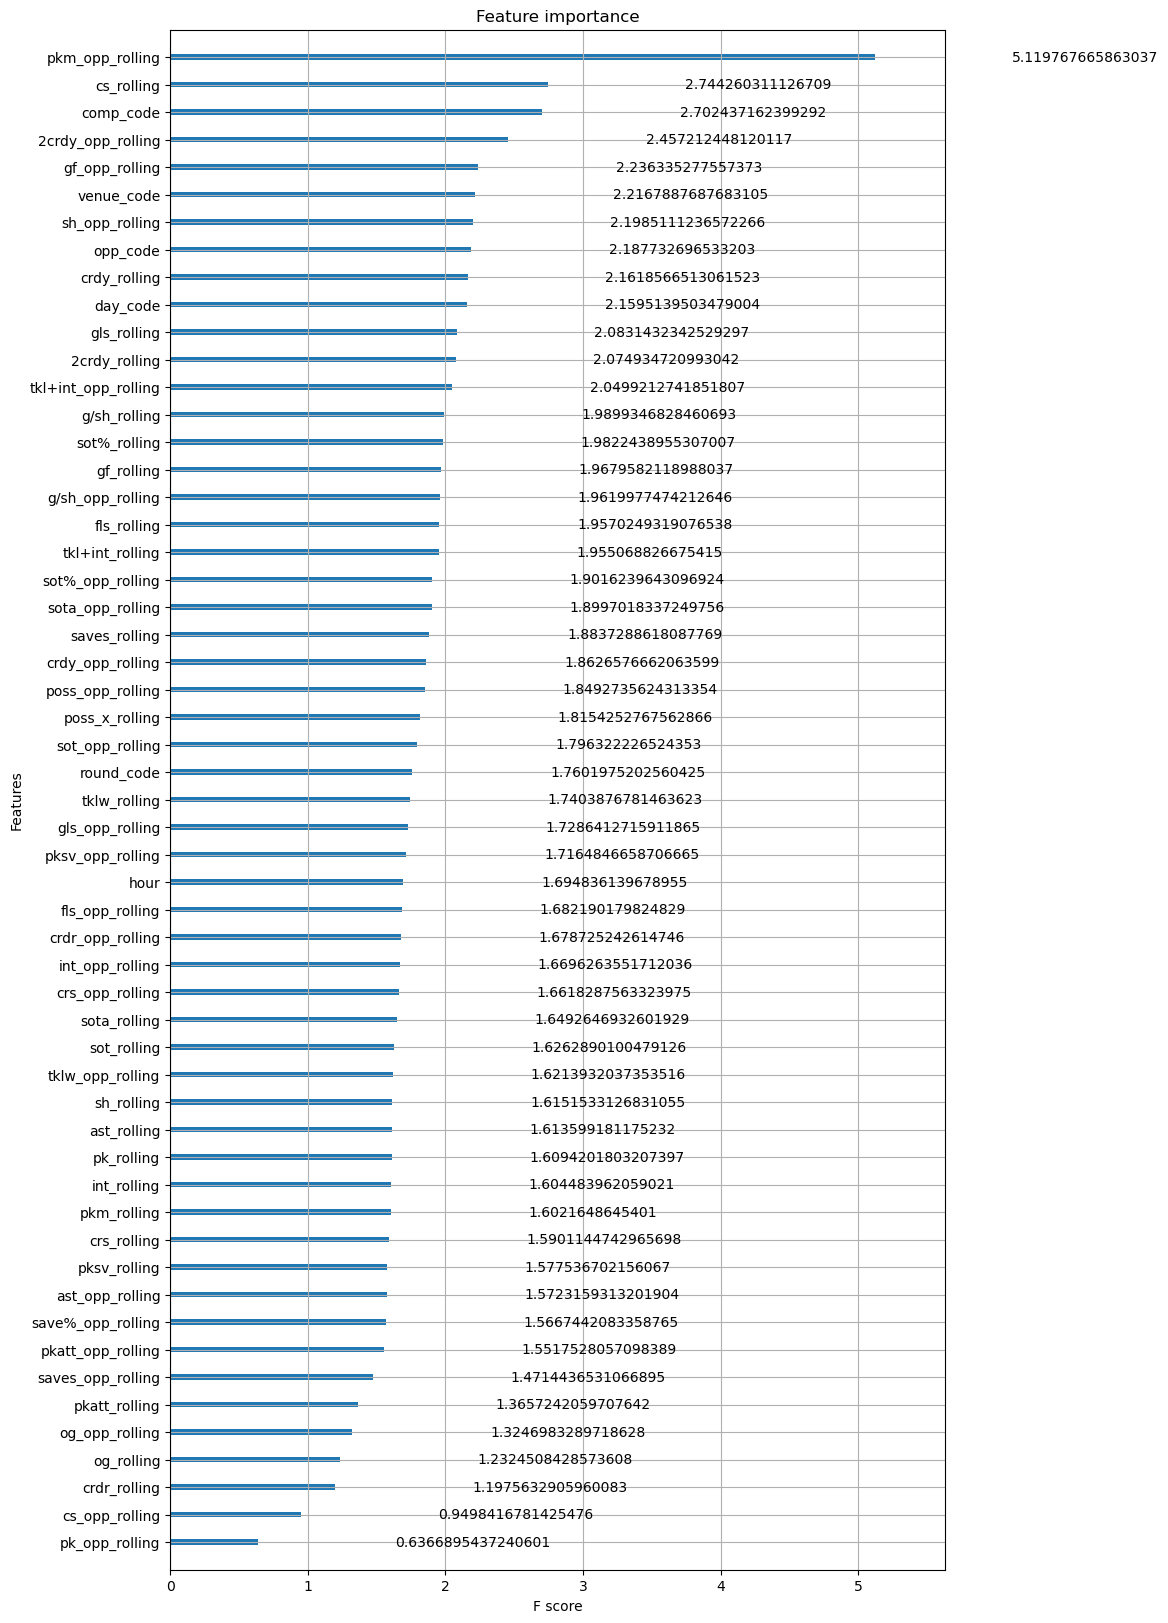

In [39]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, importance_type= 'gain', ax=ax, **kwargs)

my_plot_importance(XGB_model, (10,20))


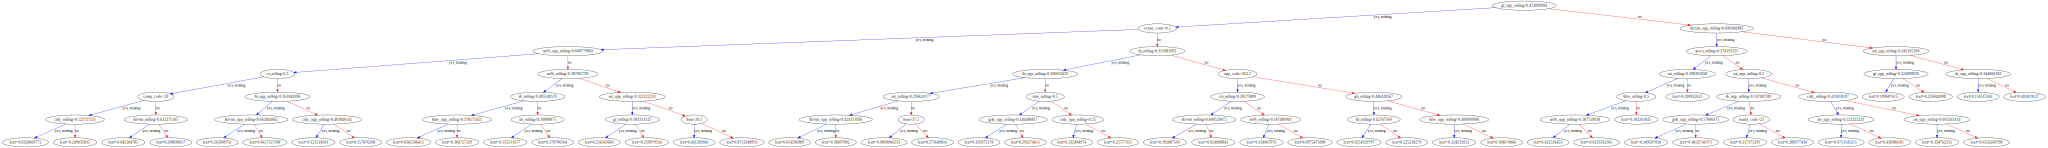

In [40]:
xgb.to_graphviz(XGB_model, num_trees=2)

In [41]:
#Available importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

f = 'gain'
# print(len(XGB_model.get_booster().get_score(importance_type= f)))
# XGB_model.get_booster().get_score(importance_type= f)

xgb_imp = pd.Series(XGB_model.get_booster().get_score(importance_type= f))
xgb_imp = xgb_imp/len(predictors3)



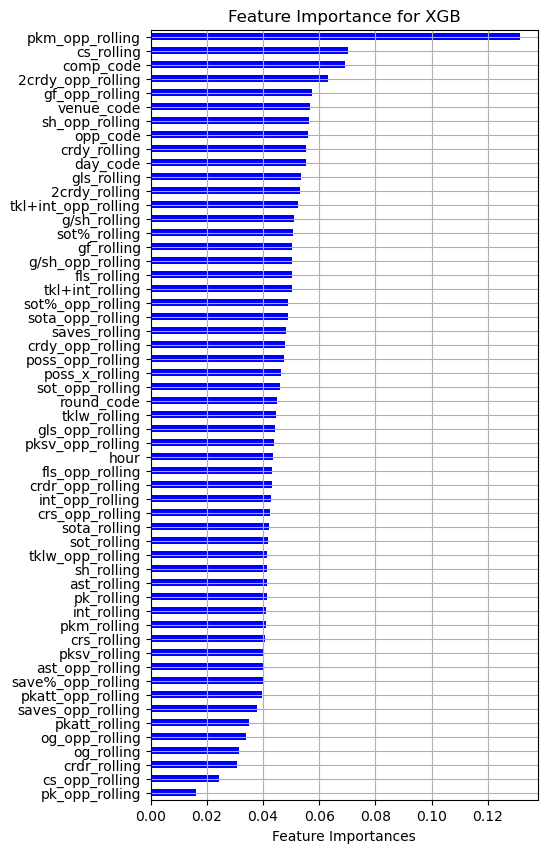

In [42]:
# Sort importances
xgb_imp_sorted = xgb_imp.sort_values()
# Draw a horizontal barplot of importances_sorted
xgb_imp_sorted.plot(kind='barh', color='blue', figsize = (5,10), grid = True, xlabel = 'Feature Importances')
plt.title('Feature Importance for XGB')
plt.show()

We note that these Random Forrest and XGBoost similar models not same ( Random forest uses bagging ensemble model while XGBoost uses boosting ensemble model), so it may differ sometimes in results. Now let me tell you why this happens.

When the correlation between the variables are high, XGBoost will pick one feature and may use it while breaking down the tree further(if required) and it will ignore some/all the other remaining correlated features(because we will not be able to learn different aspects of the model by using these correlated feature because it is already highly correlated with the chosen feature).

But in random forest , the tree is not built from specific features, rather there is random selection of features (by using row sampling and column sampling), and then the model in whole learn different correlations of different features. So you can see the procedure of two methods are different so you can expect them to behave little differently.

In [43]:
# selected_columns = ['team','venue','opponent','venue_code','opp_code','hour','day_code',
#  'gf_rolling','gls_rolling','sh_rolling','sot_rolling','sot%_rolling','g/sh_rolling',
#  'pk_rolling','pkatt_rolling','gf_opp_rolling','gls_opp_rolling','sh_opp_rolling','sot_opp_rolling',
#  'sot%_opp_rolling','g/sh_opp_rolling','pk_opp_rolling','pkatt_opp_rolling','sota_rolling',
#  'saves_rolling','cs_rolling','pka_rolling','pksv_rolling','pkm_rolling','sota_opp_rolling',
#  'saves_opp_rolling','save%_opp_rolling','cs_opp_rolling','pka_opp_rolling','pksv_opp_rolling',
#  'pkm_opp_rolling','ast_rolling','ast_opp_rolling','crs_rolling','crs_opp_rolling','tklw_rolling',
#  'int_rolling','tkl+int_rolling','tklw_opp_rolling','int_opp_rolling','tkl+int_opp_rolling',
#  'poss_x_rolling','poss_opp_rolling','crdy_rolling','crdr_rolling','2crdy_rolling', 'fls_rolling',
#  'og_rolling','crdy_opp_rolling','crdr_opp_rolling','2crdy_opp_rolling','fls_opp_rolling',
#  'og_opp_rolling','fls_rolling+sot%_rolling']